# classification with xgboost

using finalized data (`feng_v10`)

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data
import pandas as pd
import ast
import numpy as np
from numpy import mean

# visualization
import matplotlib.pyplot as plt

# chosen models
from xgboost import XGBClassifier

# feature engineering
from xgboost import plot_importance

# imbalanced data
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE


# model training selection
from sklearn.model_selection import train_test_split

## model evaluation metrics
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

# important cols
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [2]:
df = pd.read_csv('../data/feature_engineering/combined_feng_v14.4.csv', index_col=0)
df.shape

(2197, 1034)

### get data

In [3]:
X = df.drop(columns=['%female'])
y = (df['%female']>0.5).astype(int)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Imbalanced Data

In [5]:
Counter(y)

Counter({0: 2055, 1: 142})

### 1. random under-sampling

In [6]:
rus = RandomUnderSampler(random_state=42, replacement=True)

In [7]:
X_rus, y_rus = rus.fit_resample(X, y)

In [8]:
Counter(y_rus)

Counter({0: 142, 1: 142})

In [9]:
X_rus_train, X_rus_test, y_rus_train, y_rus_test = train_test_split(
    X_rus, y_rus, test_size=0.33, random_state=42)

### 2. random over-sampling

In [10]:
ros = RandomOverSampler(random_state=42)

In [11]:
X_ros, y_ros = ros.fit_resample(X, y)

In [12]:
Counter(y_ros)

Counter({0: 2055, 1: 2055})

In [13]:
X_ros_train, X_ros_test, y_ros_train, y_ros_test = train_test_split(
    X_ros, y_ros, test_size=0.33, random_state=42)

### 3. tomek links under-sampling

Tomek links are pairs of very close instances but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

Tomek’s link exists if the two samples are the nearest neighbors of each other

![img](https://miro.medium.com/max/700/1*KxFmI15rxhvKRVl-febp-Q.png)

In [14]:
tl = TomekLinks(sampling_strategy='majority')

In [15]:
X_tl, y_tl = tl.fit_resample(X, y)

In [16]:
Counter(y_tl)

Counter({0: 1980, 1: 142})

In [17]:
X_tl_train, X_tl_test, y_tl_train, y_tl_test = train_test_split(
    X_tl, y_tl, test_size=0.33, random_state=42)

### 4. synthetic minority over-sampling (SMOTE)

This technique generates synthetic data for the minority class.

SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![img](https://miro.medium.com/max/734/1*yRumRhn89acByodBz0H7oA.png)

SMOTE algorithm works in 4 simple steps:

1. Choose a minority class as the input vector
2. Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
3. Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
4. Repeat the steps until data is balanced

In [18]:
smote = SMOTE()

In [19]:
X_smote, y_smote = smote.fit_resample(X, y)

In [20]:
Counter(y_smote)

Counter({0: 2055, 1: 2055})

In [21]:
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(
    X_smote, y_smote, test_size=0.33, random_state=42)

### 5. NearMiss
NearMiss is an under-sampling technique. Instead of resampling the Minority class, using a distance, this will make the majority class equal to the minority class.

In [22]:
nm = NearMiss()

In [23]:
X_nm, y_nm = nm.fit_resample(X, y)

In [24]:
Counter(y_nm)

Counter({0: 142, 1: 142})

In [25]:
X_nm_train, X_nm_test, y_nm_train, y_nm_test = train_test_split(
    X_nm, y_nm, test_size=0.33, random_state=42)

## model evaluation

In [26]:
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) #perfect=1
#     precision = precision_score(y_true, y_pred) #perfect=1
#     recall = recall_score(y_true, y_pred) #perfect=1
    f1 = f1_score(y_true, y_pred) #perfect=1
#     roc_auc = roc_auc_score(y, clf.decision_function(X)) #perfect=1
#     log = log_loss(y_true, y_pred) #perfect=0
    mcc = matthews_corrcoef(y_true, y_pred) #perfect=1
    kappa = cohen_kappa_score(y_true, y_pred) #perfect=1
    
#     print(f'accuracy={accuracy},\
#             precision={precision}, recall={recall}, \
#             f1={f1}, mcc={mcc}, kappa={kappa}')
    
#     return [accuracy, precision, recall]
#     return [accuracy, precision, recall, f1, mcc, kappa]
    return [accuracy, f1, mcc, kappa]

In [27]:
def evaluate(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics(y_test, y_pred)

In [28]:
def important_cols(xgb):
    important_features_dict = xgb.get_booster().get_score(importance_type='weight')
    return list(important_features_dict.keys())

In [56]:
def plot_important_cols(xgb, n=50):
    plt.rcParams["figure.figsize"] = (20, 15)
    plot_importance(xgb, max_num_features=n)
    plt.xticks(fontsize=25)
    plt.xticks(fontsize=25)

In [85]:
def plot_important_cols(xgb, n=50, save=True):
#     if save==True:
    plt.figure(figsize=(50,10))
    plot_importance(xgb, max_num_features=n)
    plt.xlabel('F Score', fontsize=30)
    plt.ylabel('Features', fontsize=30)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.title('Feature Importance', fontsize=35)
#     else:
#         plt.rcParams["figure.figsize"] = (20, 15)
#         plot_importance(xgb, max_num_features=n)

## machine learning

In [30]:
xgb = XGBClassifier()

## model evaluation

### 1. random under-sampling

In [31]:
metrics_rus = evaluate(xgb, X_rus_train, X_rus_test, y_rus_train, y_rus_test)
metrics_rus

[04:29:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.648936170212766,
 0.6451612903225806,
 0.2991163165677032,
 0.29850746268656714]

In [32]:
cols_rus = important_cols(xgb)
len(cols_rus)

31

In [33]:
# plot_important_cols(xgb)

### 2. random over-sampling

In [34]:
metrics_ros = evaluate(xgb, X_ros_train, X_ros_test, y_ros_train, y_ros_test)
metrics_ros

[04:29:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.9808400884303611,
 0.9806259314456036,
 0.9623960684871085,
 0.9616895596937944]

In [35]:
cols_ros = important_cols(xgb)
len(cols_ros)

141

In [36]:
# plot_important_cols(xgb)

### 3. tomet links

In [37]:
metrics_tl = evaluate(xgb, X_tl_train, X_tl_test, y_tl_train, y_tl_test)
metrics_tl

[04:29:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.9243937232524965, 0.0, -0.020767673565578328, -0.010663474878267687]

In [38]:
cols_tl = important_cols(xgb)
len(cols_tl)

70

In [39]:
# plot_important_cols(xgb)

### 4. smote

In [40]:
metrics_smote = evaluate(xgb, X_smote_train, X_smote_test, y_smote_train, y_smote_test)
metrics_smote

[04:29:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.9439941046425939,
 0.9416282642089093,
 0.8880054992268089,
 0.8878158618964223]

In [41]:
cols_smote = important_cols(xgb)
len(cols_smote)

66

In [105]:
features = ['Medical', 'Artificial Intelligence', 'Top Investors', 'Top Industry', 'China', 'Website Monthly Visits', 
           'Last Funding Type', 'Number of Articles', 'Number of Employees', 'Estimated Revenue Range', 
            'Trademarks Registered', '% Top Industry', 'Total Products Active', 'Number of Lead Investors',
           'Number of Investors', 'Number of Founders', '% Top Investors', 'Last Funding Month',
           'Active Tech Count', 'Total Funding Amount USD']

<Figure size 720x720 with 0 Axes>

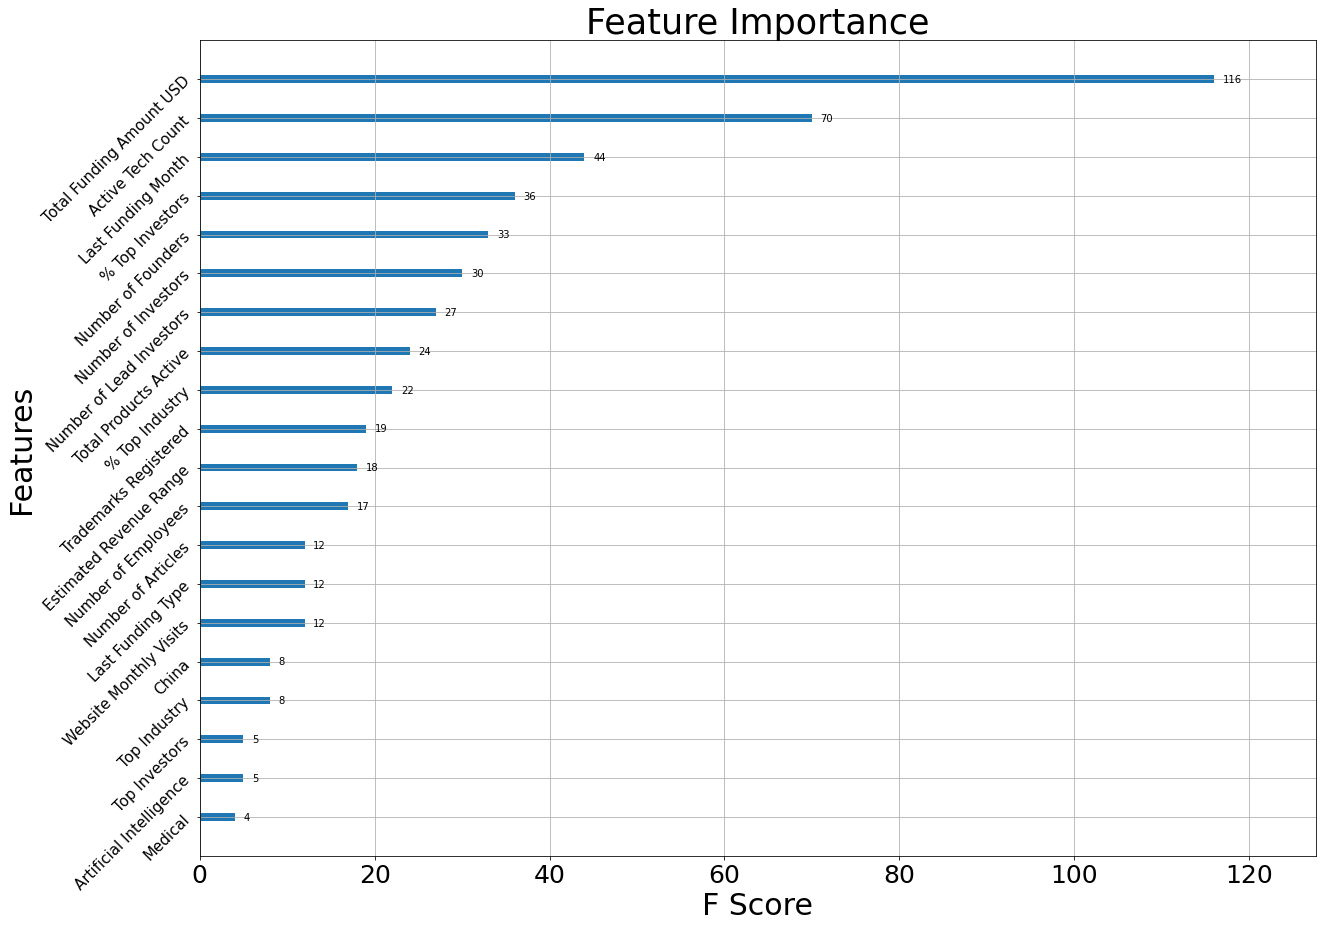

In [106]:
# plot_important_cols(xgb, save=True)
plt.figure(figsize=(10,10))
plot_importance(xgb, max_num_features=20)
plt.xlabel('F Score', fontsize=30)
plt.ylabel('Features', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(np.arange(20), features, fontsize=15, rotation=45)
plt.title('Feature Importance', fontsize=35)
plt.savefig('important_cols_bar_xgboost_v6.png')

In [43]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_smote_train)

In [44]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_smote_train.iloc[0,:])

In [45]:
columns = ['Number of Founders', 'China', '% Top Industry', '% Top Investors', 
         'Top Investor Bool', 'Europe', 'Estimated Revenue Range',
        'Total Funding Amount (USD)', 'Software Industry', 'Website Visit Duration', 
        'Number of Employees', 'Total Products Actives', 'Website Monthly Visits',
        'Top Industry Group Bool', 'Last Funding Month', 'Number of Artciles',
        'Active Tech Count', 'Trademarks Registered', 'Last Funding Type',
        'Number of Lead Investors']

In [46]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

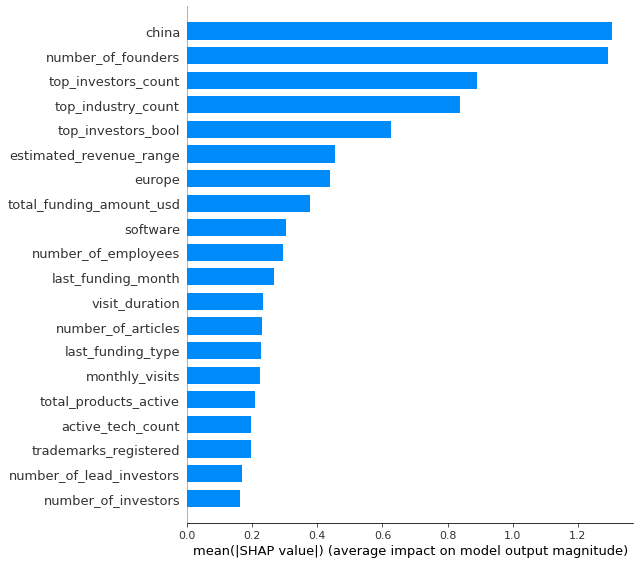

In [47]:
shap.summary_plot(shap_values, X_smote_train, plot_type="bar")

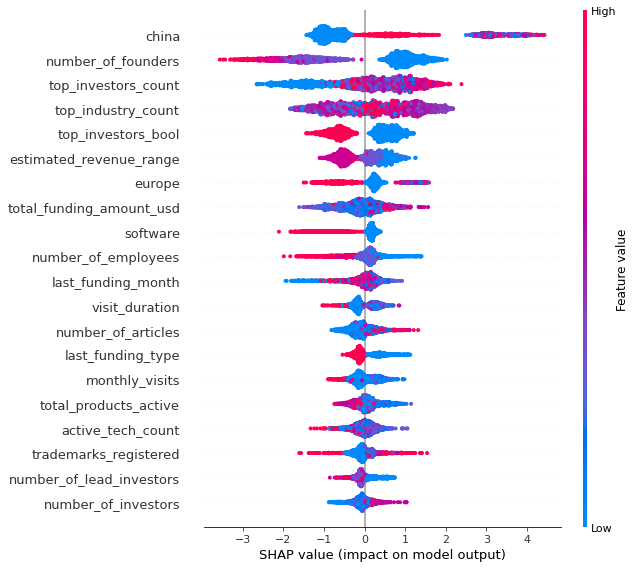

In [48]:
shap.summary_plot(shap_values, X_smote_train)

### 5. nearmiss

In [49]:
metrics_nearmiss = evaluate(xgb, X_nm_train, X_nm_test, y_nm_train, y_nm_test)
metrics_nearmiss

[04:29:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.776595744680851, 0.746987951807229, 0.5558228262694616, 0.549520766773163]

In [50]:
cols_nearmiss = important_cols(xgb)
len(cols_nearmiss)

24

In [51]:
# plot_important_cols(xgb)

FIRST: calssification to regression
- in classification we saw that there are variables that defines or differs between female and not-female-led companies, but when we single them out to understand each variable in understanding their individual effect in funding we could not 

classification found that being female interacts with other attributes of entrepreneurship, men and women don't have the same experience, we know there is a difference because when we put company information we can predict gender founders with a decently high accuracy, but at this point we don't know if there is a positive or negative impact on either

when we attempt to measure the impact of being female on funding the regression was not able to tell us the isolated contribution of gender to funding; the reasons that this could be are that 
1. the effect is not there
2. the effect is so small compared to other factors so that the rest completely washes out

SECOND: traditional economics v data science

In [52]:
# set up
algos = ['rus', 'ros', 'tomet_links', 'smote', 'nearmiss']
metrics_lst = [metrics_rus, metrics_ros, metrics_tl, metrics_smote, metrics_nearmiss]
cols_lst = [cols_rus, cols_ros, cols_tl, cols_smote, cols_nearmiss]
all_cols = list(df.columns)

# set up
metrics_data = []
cols_data = []

# loop through different weights
for i in range(len(algos)):
    
    # get metrics
    metrics_data.append(['xgboost_v5', f'{algos[i]}'] + metrics_lst[i])
    
    # get important columns
    significant_cols = cols_lst[i]
    # one hot encode important cols in all columns dataframe
    encoding = [1 if col in significant_cols else 0 for col in all_cols]
    cols_data.append(encoding)

In [53]:
df_metrics5 = pd.DataFrame(np.array(metrics_data),
                columns=['model', 'setting', 
                'accuracy', 'precision', 'recall', 'f1', 'mcc', 'kappa'])

ValueError: Shape of passed values is (5, 6), indices imply (5, 8)

In [ ]:
# df_metrics5

In [ ]:
df_cols5 = pd.DataFrame(np.array(cols_data), columns=all_cols)

In [ ]:
# df_cols5

In [ ]:
# identified as important features by more than one method
len(df_cols5.columns[df_cols5.sum()>2])

In [ ]:
df_cols5[df_cols5.columns[df_cols5.sum()>2]].columns

In [ ]:
df_metrics4 = pd.read_csv('../data/results_df/metrics_v4_dna.csv')
df_cols4 = pd.read_csv('../data/results_df/important_cols_v4_dna.csv')

In [ ]:
df_metrics = pd.concat([df_metrics4, df_metrics5])

In [ ]:
df_cols = pd.concat([df_cols4, df_cols5])

In [ ]:
# df_metrics.to_csv('../data/results_df/metrics_v456_dna.csv', index=False)

In [ ]:
# df_cols.to_csv('../data/results_df/important_cols_v456_dna.csv', index=False)

### Feature Selection
Somehow the selected PCA columns also resulted in a very different feature selection in the xgboost model compared to the first time. 
- v1: 92/7532
- v2: 6/100
- v3: 48/1352
- v4:  79/1352
- v5: 
    - random under-sampling: 25/1352
    - random over-sampling: 79/1352
    - tomet links: 39/1352
    - smote: 45/1352
    - nearmiss: 21/1352

v1-v3 does not deal with imbalance of the dataset

### Version Differences

model_version | feature selection | imbalanced class | hyperparameter tuning | cross validation
--------------|-------------------|------------------|-----------------------|-----------------
xgboost_v1 | no | no | no | no
xgboost_v2 | yes, top100 | no | no | no
xgboost_v3 | yes, top all 1352 | no | no | no
xgboost_v4 | yes, top all 1352 | yes (weighted 20-50) | no | no
xgboost_v5 | yes, top all 1352 | yes (under/over-sampling * 5) | no | no